In [48]:
import numpy as np
import pandas as pd

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.cm as cm

import tensorflow as tf

# settings
LEARNING_RATE = 1e-4
# set to 20000 on local environment to get 0.99 accuracy
# 在本地环境上设置为20000可获得0.99精度
TRAINING_ITERATIONS = 2500        
    
DROPOUT = 0.5
BATCH_SIZE = 50

# set to 0 to train on all available data
# 设置为0以训练所有可用数据
VALIDATION_SIZE = 2000

# image number to output
# 要输出的图像编号
IMAGE_TO_DISPLAY = 10

In [49]:
# read training data from CSV file 
data = pd.read_csv('train.csv')
print(data.shape)

print('data({0[0]},{0[1]})'.format(data.shape))
print (data.head())

(42000, 785)
data(42000,785)
   label  pixel0  pixel1  pixel2  pixel3  pixel4  pixel5  pixel6  pixel7  \
0      1       0       0       0       0       0       0       0       0   
1      0       0       0       0       0       0       0       0       0   
2      1       0       0       0       0       0       0       0       0   
3      4       0       0       0       0       0       0       0       0   
4      0       0       0       0       0       0       0       0       0   

   pixel8  ...  pixel774  pixel775  pixel776  pixel777  pixel778  pixel779  \
0       0  ...         0         0         0         0         0         0   
1       0  ...         0         0         0         0         0         0   
2       0  ...         0         0         0         0         0         0   
3       0  ...         0         0         0         0         0         0   
4       0  ...         0         0         0         0         0         0   

   pixel780  pixel781  pixel782  pixel783  
0

In [50]:
images = data.iloc[:,1:].values
print(images.shape)
images = images.astype(np.float)
print(type(images))

# convert from [0:255] => [0.0:1.0]
images = np.multiply(images, 1.0 / 255.0)
print(type(images))

print('images({0[0]},{0[1]})'.format(images.shape))

(42000, 784)
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
images(42000,784)


In [51]:
image_size = images.shape[1]
print ('image_size => {0}'.format(image_size))

# in this case all images are square
# 在这种情况下，所有图像都是正方形的
image_width = image_height = np.ceil(np.sqrt(image_size)).astype(np.uint8)
# np.ceil() 计算大于等于该值的最小整数，其实就是向上取整
# uint8是无符号八位整型，表示范围是[0, 255]的整数
# 如果需要转回PIL的图像对象，那就必须是uint8的格式

print ('image_width => {0}\nimage_height => {1}'.format(image_width,image_height))

image_size => 784
image_width => 28
image_height => 28


(42000, 784)
(784,)
[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.

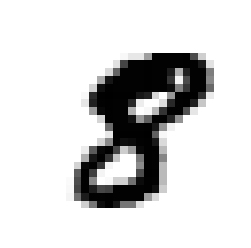

In [52]:
def display(img):
    
    # (784) => (28,28)
    one_image = img.reshape(image_width,image_height)  # 需要将其转换成一种图像的格式，才可以进行后面imshow图像的展示，图像是由长和宽组成的
    
    plt.axis('off')
    # plt.gray()：只有黑白两色，没有中间的渐进色
    # 1. 关闭坐标刻度  plt.xticks([]) plt.yticks([])   关闭坐标轴：plt.axis('off')
    # 注意，类似的这些操作若想起作用，需要将其置于 plt.show() 之前，plt.imshow() 之后。
    # 2. 设置所要保存图像的 dpi  dpi：Dots Per Inch  plt.savefig(..., dpi=150)
    # 3. 坐标轴不可见
    # frame = plt.gca()
    # y 轴不可见
    # frame.axes.get_yaxis().set_visible(False)
    # x 轴不可见
    # frame.axes.get_xaxis().set_visible(False)
    plt.imshow(one_image, cmap=cm.binary)    

# output image  
# 要输出的图像编号
# IMAGE_TO_DISPLAY = 10
print(images.shape)
print(images[IMAGE_TO_DISPLAY].shape)
print(images[IMAGE_TO_DISPLAY])
display(images[IMAGE_TO_DISPLAY])

In [53]:
print(data.shape)
# labels_flat = data[[0]].values.ravel()
print(data.iloc[:,0].values.shape)
labels_flat = data.iloc[:,0].values.ravel()
print(type(labels_flat))
print(labels_flat.shape)

print('labels_flat({0})'.format(len(labels_flat)))
print ('labels_flat[{0}] => {1}'.format(IMAGE_TO_DISPLAY,labels_flat[IMAGE_TO_DISPLAY]))

(42000, 785)
(42000,)
<class 'numpy.ndarray'>
(42000,)
labels_flat(42000)
labels_flat[10] => 8


In [54]:
print(np.unique(labels_flat))
print(np.unique(labels_flat).shape)
labels_count = np.unique(labels_flat).shape[0]

print('labels_count => {0}'.format(labels_count))

[0 1 2 3 4 5 6 7 8 9]
(10,)
labels_count => 10


In [55]:
# convert class labels from scalars to one-hot vectors
# 将类标签从标量转换为一键矢量
# 0 => [1 0 0 0 0 0 0 0 0 0]
# 1 => [0 1 0 0 0 0 0 0 0 0]
# ...
# 9 => [0 0 0 0 0 0 0 0 0 1]
def dense_to_one_hot(labels_dense, num_classes):
    num_labels = labels_dense.shape[0]  # 42000
    index_offset = np.arange(num_labels) * num_classes  
    print(index_offset)
    print(index_offset.shape)
    labels_one_hot = np.zeros((num_labels, num_classes))
    print(labels_one_hot)
    print(labels_one_hot.shape)
    print(labels_dense.ravel())  # 就是将标签给扁平化处理了呗
    print(type(labels_one_hot))
    print(index_offset + labels_dense.ravel())
    print((index_offset + labels_dense.ravel()).shape)
    print('别逼我了')
    print(labels_one_hot.flat[index_offset + labels_dense.ravel()]) # 这些项都被取出来了，后面赋值为1
    # flat本身是数组重组的意思，这里是起到一个赋值的作用
    print((labels_one_hot.flat[index_offset + labels_dense.ravel()]).shape)
    labels_one_hot.flat[index_offset + labels_dense.ravel()] = 1
    print(labels_one_hot)
    print(labels_one_hot.shape)
    return labels_one_hot

labels = dense_to_one_hot(labels_flat, labels_count)  # labels_flat为(42000,)，labels_count为10
labels = labels.astype(np.uint8)

print('labels({0[0]},{0[1]})'.format(labels.shape))
print ('labels[{0}] => {1}'.format(IMAGE_TO_DISPLAY,labels[IMAGE_TO_DISPLAY]))

[     0     10     20 ... 419970 419980 419990]
(42000,)
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
(42000, 10)
[1 0 1 ... 7 6 9]
<class 'numpy.ndarray'>
[     1     10     21 ... 419977 419986 419999]
(42000,)
别逼我了
[0. 0. 0. ... 0. 0. 0.]
(42000,)
[[0. 1. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 1. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 1.]]
(42000, 10)
labels(42000,10)
labels[10] => [0 0 0 0 0 0 0 0 1 0]


In [56]:
# split data into training & validation
# 将数据分为训练集和验证集
# VALIDATION_SIZE = 2000  这是验证集的大小
validation_images = images[:VALIDATION_SIZE]
validation_labels = labels[:VALIDATION_SIZE]

train_images = images[VALIDATION_SIZE:]
train_labels = labels[VALIDATION_SIZE:]


print('train_images({0[0]},{0[1]})'.format(train_images.shape))
print('validation_images({0[0]},{0[1]})'.format(validation_images.shape))

train_images(40000,784)
validation_images(2000,784)


In [57]:
# weight initialization
# 权重初始化
def weight_variable(shape):
    initial = tf.truncated_normal(shape, stddev=0.1)  # 初始化用高斯分布
    # tf.truncated_normal与tf.random_normal的作用都是从给定均值和方差的正态分布中输出变量。两者的区别在于tf.truncated_normal 截取的是两个标
    # 准差以内的部分，换句话说就是截取随机变量更接近于均值。
    return tf.Variable(initial) # 这一步必不可少，转化为tf支持的格式

def bias_variable(shape):
    initial = tf.constant(0.1, shape=shape)  # 初始化用常量
    return tf.Variable(initial)

In [58]:
def conv2d(x, W):  # 卷积
    return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')
    # tf.nn.conv2d就是对原始的数据进行卷积的操作
    # x就是输入
    # W就相当于是一个小的窗口，用两个小的窗口去求这样一个内积的操作
    # strides是说卷积怎么滑，中间两个1是说沿着长和宽都是1*1的，左边和右边的1分别代表是在batch上和在channel上怎么1 
    # 如果你想一次性移动2*2的单元格，把中间两个1都改成2就可以了，两旁的1一般不改变
    # padding是指填充的意思，在原始图像上进行边缘填充
    

In [59]:
# pooling
# [[0,3],
#  [4,2]] => 4

# [[0,1],
#  [1,1]] => 1

def max_pool_2x2(x):  # 池化
    # 这个应该是池化的操作，对当前的特征图也是进行一次特征的提取，只把最大的值保留出来，其他的值全要过滤掉，为了使得我们的特征图能够
    # 进行一个压缩的操作
    return tf.nn.max_pool(x, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')
    # x还是输入的意思，strides还是指滑动的步长
    # ksize是说要指定一个多大的窗口，指定一个2*2，就是说要在2*2的区域里去找这样一个最大的值

In [60]:
# input & output of NN

# images
# 输入就是由像素点组成的矩阵
# BATCH_SIZE = 50
x = tf.placeholder('float', shape=[None, image_size])  # 先不指定实际的batch是多大的，先占一个坑再说，坑里有多少个数据暂时不知道，先把结构给定义出来
print(x.shape)
# labels
y_ = tf.placeholder('float', shape=[None, labels_count])
print(y.shape)

(?, 784)
(?, 10)


In [61]:
# first convolutional layer
# 第一卷积层
W_conv1 = weight_variable([5, 5, 1, 32])  
# W是滑动窗口特征提取的作用，从W1-W32，最终可以得到32组特征，这32组特征项堆叠起来得到一个新的特征图，在新的特征图上深度就是等于32的
# 在原始图像上找的窗口的大小是5*5，W前面连的输入深度/channel是1，32指后面想得到多少个特征图
# 32就是指你最终想得到多少个特征图
b_conv1 = bias_variable([32]) 
# 32个特征图中每个特征图都会有一个b

# (40000,784) => (40000,28,28,1)
image = tf.reshape(x, [-1,image_width , image_height,1])  # batch_size用-1来表示，是实际推断出来的
# 在计算时需要将输入，就是image稍微做一些改变
#print (image.get_shape()) # =>(40000,28,28,1)


h_conv1 = tf.nn.relu(conv2d(image, W_conv1) + b_conv1)
#print (h_conv1.get_shape()) # => (40000, 28, 28, 32)
h_pool1 = max_pool_2x2(h_conv1)
#print (h_pool1.get_shape()) # => (40000, 14, 14, 32)


In [62]:
# second convolutional layer
# 第二卷积层
W_conv2 = weight_variable([5, 5, 32, 64])
print(W_conv2.shape)
b_conv2 = bias_variable([64])

h_conv2 = tf.nn.relu(conv2d(h_pool1, W_conv2) + b_conv2) # 卷积
print(h_conv2.shape)
#print (h_conv2.get_shape()) # => (40000, 14,14, 64)
h_pool2 = max_pool_2x2(h_conv2)  # 卷积完后再经过一层池化层进行一个特征的再压缩
print(h_pool2.shape)
#print (h_pool2.get_shape()) # => (40000, 7, 7, 64)
# 大小是7*7的，用64个这样7*7的大小，形成了这样一个特征图



(5, 5, 32, 64)
(?, 14, 14, 64)
(?, 7, 7, 64)


In [63]:
# 准备进行权连接(wx+b)的操作，因为特征图是利用不了的，要将特征图转化为向量的格式进行操作
# densely connected layer
# 紧密连接层
W_fc1 = weight_variable([7 * 7 * 64, 1024])  # 想得到一个1024维的向量
print(W_fc1.shape)
b_fc1 = bias_variable([1024])
print(b_fc1.shape)

# (40000, 7, 7, 64) => (40000, 3136)
h_pool2_flat = tf.reshape(h_pool2, [-1, 7*7*64])
print(h_pool2_flat.shape)

h_fc1 = tf.nn.relu(tf.matmul(h_pool2_flat, W_fc1) + b_fc1)   # 就是为了将维度转化为1024啊，维度其实就是特征图的意思吧
print(h_fc1.shape)
#print (h_fc1.get_shape()) # => (40000, 1024)

(3136, 1024)
(1024,)
(?, 3136)
(?, 1024)


In [64]:
# dropout
keep_prob = tf.placeholder('float')  # 要设置一个保留率
print(type(keep_prob))
h_fc1_drop = tf.nn.dropout(h_fc1, keep_prob)
print(type(h_fc1_drop))
print(h_fc1_drop.shape)

<class 'tensorflow.python.framework.ops.Tensor'>
<class 'tensorflow.python.framework.ops.Tensor'>
(?, 1024)


In [65]:
# readout layer for deep net
# 深度网络的输出层
W_fc2 = weight_variable([1024, labels_count])  # labels_count=10
print(W_fc2.shape)
b_fc2 = bias_variable([labels_count])

y = tf.nn.softmax(tf.matmul(h_fc1_drop, W_fc2) + b_fc2)  # 将1024维转化为10维输出，维度其实就是特征图的意思吧
print(y.shape)

#print (y.get_shape()) # => (40000, 10)

# 卷积池化神经网络是有很多特征提取和最终特征整合的操作

(1024, 10)
(?, 10)


In [66]:
# cost function
# 成本函数
cross_entropy = -tf.reduce_sum(y_*tf.log(y))  # 用了一种交叉熵的形式  
# 这是softmax的损失函数表示么
# tf.reduce_sum ：计算tensor指定轴方向上的所有元素的累加和
# tf.reduce_max  :  计算tensor指定轴方向上的各个元素的最大值
# tf.reduce_all :  计算tensor指定轴方向上的各个元素的逻辑和（and运算）
# tf.reduce_any:  计算tensor指定轴方向上的各个元素的逻辑或（or运算）


# optimisation function
# 优化函数 优化器
# LEARNING_RATE = 1e-4
train_step = tf.train.GradientDescentOptimizer(LEARNING_RATE).minimize(cross_entropy)  # 这里是梯度下降的优化方式，要最小化损失函数

# evaluation
correct_prediction = tf.equal(tf.argmax(y,1), tf.argmax(y_,1))  # 用tf.equal来预测一下预测值和真实值是否相等
# tf.argmax(input,axis)根据axis取值的不同返回每行或者每列最大值的索引
# axis=0时比较每一列的元素，将每一列最大元素所在的索引记录下来，最后输出每一列最大元素所在的索引数组
# axis=1的时候，将每一行最大元素所在的索引记录下来，最后返回每一行最大元素所在的索引数组

accuracy = tf.reduce_mean(tf.cast(correct_prediction, 'float'))
# tf.cast()函数的作用是执行 tensorflow 中张量数据类型转换，比如读入的图片如果是int8类型的，一般在要在训练前把图像的数据格式转换为float32
# tf.reduce_mean 函数用于计算张量tensor沿着指定的数轴（tensor的某一维度）上的的平均值，主要用作降维或者计算tensor（图像）的平均值

In [67]:
# prediction function
#[0.1, 0.9, 0.2, 0.1, 0.1 0.3, 0.5, 0.1, 0.2, 0.3] => 1
predict = tf.argmax(y,1)
print(predict)
print(predict.shape)

Tensor("ArgMax_6:0", shape=(?,), dtype=int64)
(?,)


In [68]:
epochs_completed = 0  # 迭代完成
index_in_epoch = 0  # 迭代的索引
# train_images = images[VALIDATION_SIZE:]
# train_images(40000,784)
num_examples = train_images.shape[0]  # 这个指样本训练集的数量，就是40000

# serve data by batches
# 分批提供数据
# BATCH_SIZE = 50
def next_batch(batch_size):
    
    global train_images
    global train_labels
    global index_in_epoch
    global epochs_completed
    
    start = index_in_epoch  # 一开始是0
    index_in_epoch += batch_size  # 迭代的索引是随着子训练集增加的，每一次循环增加一个子训练集的数量
    
    # when all trainig data have been already used, it is reorder randomly    
    # 当所有训练数据都已使用后，将对其随机重新排序
    if index_in_epoch > num_examples:
        # finished epoch
        # 结束迭代
        epochs_completed += 1  # 这就完成了一次epoch了
        # shuffle the data
        # 随机整理数据
        perm = np.arange(num_examples) 
        np.random.shuffle(perm)  # 这不很明显是把数据的索引给打乱了么
        train_images = train_images[perm]  # 顺序打乱了后这就是新的训练数据
        train_labels = train_labels[perm]  # 顺序打乱了后这就是新的训练数据标签
        # start next epoch
        # 开始下一个epoch
        start = 0
        index_in_epoch = batch_size  # 还是会选择一个batch一个batch的迭代
        assert batch_size <= num_examples  # 这个是断言
    end = index_in_epoch
    return train_images[start:end], train_labels[start:end]

In [69]:
# start TensorFlow session
# 开始TensorFlow会话
init = tf.initialize_all_variables()  # 对于tf变量来说，初始化必不可少，这里初始化所有定义的变量
sess = tf.InteractiveSession()  # 指定这样一个交互的图结构
# 在tensorflow当中，找一个可以计算的图的区域，tensorflow所有的结构都是一种图的结构，找这样一个计算区域帮我们去算这个事儿

sess.run(init)

C:\Users\asus\Anaconda3\envs\tensorflow\lib\site-packages\tensorflow\python\client\session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


In [70]:
# visualisation variables
# 可视化变量
train_accuracies = []  # 训练集精度
validation_accuracies = []  # 验证集精度
x_range = []  # x的范围

display_step=1  # 显示步骤

for i in range(TRAINING_ITERATIONS):  # TRAINING_ITERATIONS = 2500

    # get new batch
    # BATCH_SIZE = 50
    batch_xs, batch_ys = next_batch(BATCH_SIZE)   # 每次迭代后batch_xs, batch_ys应该是都会有所变化的，样本训练集的数量有40000份呢
    # next_batch(batch_size)返回的是train_images[start:end], train_labels[start:end]

    # check progress on every 1st,2nd,...,10th,20th,...,100th... step
    # 每1、2，...，10、20，...，100 ...步骤检查进度
    # 看一下当前的结果在训练集和验证集上的效果怎么样
    # display_step=10后，i就直接跳到了20,30...100才满足
    # display_step=100后，i就直接跳到了200...1000才满足
    # display_step=1000后，i就直接跳到了2000才满足，外加一个2449
    if i%display_step == 0 or (i+1) == TRAINING_ITERATIONS:  # i%display_step,求余，就是整除，或者就是i=2449
        
        train_accuracy = accuracy.eval(feed_dict={x:batch_xs, 
                                                  y_: batch_ys, 
                                                  keep_prob: 1.0})       
        if(VALIDATION_SIZE):  # VALIDATION_SIZE = 2000  2000/50 = 40  这里应该是只要VALIDATION_SIZE不为0即满足条件
            # validation_images = images[:VALIDATION_SIZE]  validation_images(2000,784)
            # validation_labels = labels[:VALIDATION_SIZE]
            validation_accuracy = accuracy.eval(feed_dict={ x: validation_images[0:BATCH_SIZE], 
                                                            y_: validation_labels[0:BATCH_SIZE], 
                                                            keep_prob: 1.0})
            # 这里才是让我费解的点，因为验证集一共有2000份，但是validation_images[0:BATCH_SIZE]这个东西每次不是不变的么
            # 所以吧，每次打出的都是验证同一份验证集的精度
            print('training_accuracy / validation_accuracy => %.2f / %.2f for step %d'%(train_accuracy, validation_accuracy, i))
            
            validation_accuracies.append(validation_accuracy)
            
        else:  # 这个从未用到，也不知道摆在这里干嘛
             print('training_accuracy => %.4f for step %d'%(train_accuracy, i))
        train_accuracies.append(train_accuracy)
        x_range.append(i)
        
        # increase display_step
        # display_step变成10后，i就直接跳到了100才满足
        # display_step变成100后，i就直接跳到了1000才满足，然后就没有然后了，迭代完毕
        if i%(display_step*10) == 0 and i:  # 0%10 = 0并且i不为0才行，也就是说要是能整除10的数，首先就是10自己
            display_step *= 10  # display_step从1变成了10
    # train on batch
    # 在子训练集上进行训练
    sess.run(train_step, feed_dict={x: batch_xs, y_: batch_ys, keep_prob: DROPOUT})
    # 这一步太重要了吧，是解决一切关键问题的关键，同时也解释了为什么每次都要使用下一份训练集进行训练

training_accuracy / validation_accuracy => 0.12 / 0.16 for step 0
training_accuracy / validation_accuracy => 0.18 / 0.16 for step 1
training_accuracy / validation_accuracy => 0.20 / 0.12 for step 2
training_accuracy / validation_accuracy => 0.10 / 0.16 for step 3
training_accuracy / validation_accuracy => 0.06 / 0.14 for step 4
training_accuracy / validation_accuracy => 0.18 / 0.28 for step 5
training_accuracy / validation_accuracy => 0.16 / 0.30 for step 6
training_accuracy / validation_accuracy => 0.32 / 0.34 for step 7
training_accuracy / validation_accuracy => 0.38 / 0.32 for step 8
training_accuracy / validation_accuracy => 0.24 / 0.36 for step 9
training_accuracy / validation_accuracy => 0.48 / 0.32 for step 10
training_accuracy / validation_accuracy => 0.38 / 0.54 for step 20
training_accuracy / validation_accuracy => 0.52 / 0.60 for step 30
training_accuracy / validation_accuracy => 0.42 / 0.58 for step 40
training_accuracy / validation_accuracy => 0.70 / 0.68 for step 50
train

validation_accuracy => 0.9705


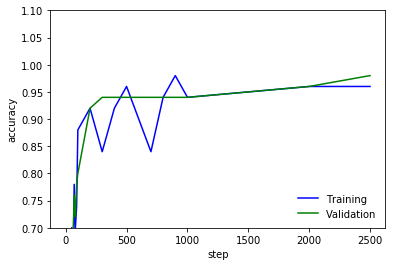

In [74]:
# check final accuracy on validation set 
# 检查验证集的最终准确性
if(VALIDATION_SIZE):
    validation_accuracy = accuracy.eval(feed_dict={x: validation_images, 
                                                   y_: validation_labels, 
                                                   keep_prob: 1.0})
    print('validation_accuracy => %.4f'%validation_accuracy)
    plt.plot(x_range, train_accuracies,'-b', label='Training')
    plt.plot(x_range, validation_accuracies,'-g', label='Validation')
    plt.legend(loc='lower right', frameon=False)  # 删除框中的图  frameon=False
    # plt.legend(loc='lower right', frameon=True)
    # plt.ylim(ymax = 1.1, ymin = 0.7)
    plt.ylim(top = 1.1, bottom = 0.7)
    plt.ylabel('accuracy')
    plt.xlabel('step')
    plt.show()

In [ ]:
 474241623